# CIFAR10でCNNを用いた画像分類(Keras)

詳細は以下の記事に記してあります。
https://qiita.com/souring001/items/1bf78219b14a8224d4d8

## 乱数の固定

再現性を持たせるため乱数を固定する。

しかし、lossやaccuracyは毎回異なる。(原因究明中)

In [1]:
import numpy as np
import tensorflow as tf
import random as rn

# Python 3.2.3以降で必要、ハッシュベースの操作に関して再現性を持たせる
import os
os.environ['PYTHONHASHSEED'] = '0'

# Numpy, Pythonでの乱数の固定
np.random.seed(42)
rn.seed(12345)

# TensorFlowはマルチスレッドだと再現性が無いので、シングルスレッドにする
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# TensorFlowのバックエンドの乱数を固定
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

Using TensorFlow backend.


## ライブラリのインポート

In [2]:
import keras
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

## データセット準備

データをロード

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

データ型はfloat32に変換し、0~255を0~1とする。

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

ラベルはOne-Hotベクトルにする

In [5]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

正しく準備できたか確認

In [6]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('x_train shape:', x_train.shape, '\tdtype:', x_train.dtype)
print('y_train shape:', y_train.shape, '\t\tdtype:', y_train.dtype)
print('x_test shape:', x_test.shape, '\tdtype:', x_test.dtype)
print('y_test shape:', y_test.shape, '\t\tdtype:', y_test.dtype)

50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3) 	dtype: float32
y_train shape: (50000, 10) 		dtype: float32
x_test shape: (10000, 32, 32, 3) 	dtype: float32
y_test shape: (10000, 10) 		dtype: float32


データの中身を確認

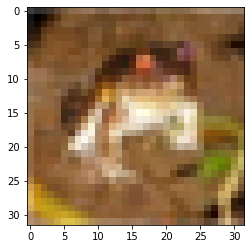

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [7]:
idx = 0 # i番目のデータ
plt.imshow(x_train[idx])
plt.show()
print(y_train[idx])

## ネットワークの作成

In [37]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

最適化アルゴリズム(Optimizer)の初期化

In [38]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam()

ロス関数や最適化アルゴリズムを設定する

In [39]:
model.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

モデルの要約を出力

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
__________

## 学習

In [41]:
batch_size = 32
epochs = 20

### データ拡張なしの場合

In [42]:
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 199us/step - loss: 1.5217 - acc: 0.4453 - val_loss: 1.1986 - val_acc: 0.5844
Epoch 2/20
50000/50000 [==============================] - 9s 187us/step - loss: 1.1397 - acc: 0.5983 - val_loss: 1.0012 - val_acc: 0.6517
Epoch 3/20
50000/50000 [==============================] - 9s 186us/step - loss: 0.9908 - acc: 0.6483 - val_loss: 0.8920 - val_acc: 0.6910
Epoch 4/20
50000/50000 [==============================] - 10s 190us/step - loss: 0.8993 - acc: 0.6857 - val_loss: 0.8386 - val_acc: 0.7072
Epoch 5/20
50000/50000 [==============================] - 9s 188us/step - loss: 0.8358 - acc: 0.7062 - val_loss: 0.7610 - val_acc: 0.7382
Epoch 6/20
50000/50000 [==============================] - 10s 191us/step - loss: 0.7843 - acc: 0.7253 - val_loss: 0.7666 - val_acc: 0.7370
Epoch 7/20
50000/50000 [==============================] - 10s 193us/step - loss: 0.7515 - acc: 0.7376 - val_loss: 0.722

### データ拡張ありの場合

In [28]:
num_train_samples = x_train.shape[0] # 50000

datagen = ImageDataGenerator(
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.2,
                zoom_range=0.2,
                rotation_range=20,
                horizontal_flip=True
                )


# datagen.fit(x_train) # featurewise_center, featurewise_std_normalization, zca_whiteningが指定されたときに必要

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)



データ拡張後の中身を確認

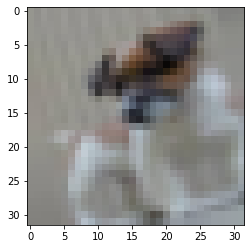

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [29]:
batch = train_generator.next()
x, y = batch

idx = 0 # i番目のデータ
plt.imshow(x[idx])
plt.show()
print(y[idx])

学習

In [30]:
model.fit_generator(train_generator,
                                epochs=epochs,
                                steps_per_epoch=num_train_samples/batch_size,
                                validation_data=(x_test, y_test))

Epoch 1/20
1563/1562 [==============================] - 18s 12ms/step - loss: 1.6845 - acc: 0.3773 - val_loss: 1.2435 - val_acc: 0.5493
Epoch 2/20
1563/1562 [==============================] - 18s 11ms/step - loss: 1.3629 - acc: 0.5104 - val_loss: 1.2041 - val_acc: 0.5694
Epoch 3/20
1563/1562 [==============================] - 18s 11ms/step - loss: 1.2410 - acc: 0.5587 - val_loss: 1.0017 - val_acc: 0.6451
Epoch 4/20
1563/1562 [==============================] - 18s 11ms/step - loss: 1.1805 - acc: 0.5831 - val_loss: 1.0197 - val_acc: 0.6370
Epoch 5/20
1563/1562 [==============================] - 18s 11ms/step - loss: 1.1338 - acc: 0.5998 - val_loss: 1.0224 - val_acc: 0.6391
Epoch 6/20
1563/1562 [==============================] - 18s 12ms/step - loss: 1.0924 - acc: 0.6118 - val_loss: 1.0412 - val_acc: 0.6362
Epoch 7/20
1563/1562 [==============================] - 18s 11ms/step - loss: 1.0660 - acc: 0.6231 - val_loss: 0.8505 - val_acc: 0.7009
Epoch 8/20
1563/1562 [==========================

### 転移学習

imagenetでpre-trainedされたVGG16を使用して、出力層側にある3つの全結合層のみを学習させる。

Sequentialモデルではなく、Functional APIを使う。

`trainable`を`False`として、ネットワークの前半部分をfreezeして重みを更新しなくする。

In [34]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ネットワークの前半部分をfreezeして重み更新をしない。
for layer in model.layers[:19]:
    print(layer.name)
    layer.trainable = False
    
opt = Adam()

model.compile(loss='categorical_crossentropy',
                        optimizer=opt,
                        metrics=['accuracy'])

model.summary()

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_____________________________________

過学習気味の結果となった

In [35]:
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 40s 795us/step - loss: 1.3505 - acc: 0.5296 - val_loss: 1.2530 - val_acc: 0.5630
Epoch 2/20
50000/50000 [==============================] - 39s 780us/step - loss: 1.1605 - acc: 0.5951 - val_loss: 1.1921 - val_acc: 0.5832
Epoch 3/20
50000/50000 [==============================] - 39s 783us/step - loss: 1.0800 - acc: 0.6217 - val_loss: 1.1436 - val_acc: 0.5988
Epoch 4/20
50000/50000 [==============================] - 39s 784us/step - loss: 1.0105 - acc: 0.6429 - val_loss: 1.1416 - val_acc: 0.6048
Epoch 5/20
50000/50000 [==============================] - 39s 782us/step - loss: 0.9473 - acc: 0.6635 - val_loss: 1.1679 - val_acc: 0.6050
Epoch 6/20
50000/50000 [==============================] - 39s 781us/step - loss: 0.8818 - acc: 0.6840 - val_loss: 1.1922 - val_acc: 0.6044
Epoch 7/20
50000/50000 [==============================] - 39s 783us/step - loss: 0.8126 - acc: 0.7061 - val_loss: 1.

## 学習したモデルを用いて推定

`model.predict(x)`で学習済みモデルを用いて推定を行う。

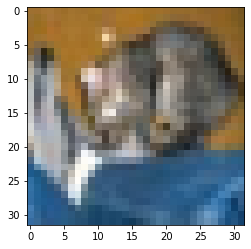

[8.4338727e-04 5.1493221e-03 2.4219223e-03 4.6394268e-01 9.4345458e-05
 4.6124420e-01 1.0937045e-02 1.1056146e-03 5.0766073e-02 3.4954564e-03]
pred_y: 3 , label: 3


In [43]:
y = model.predict(x_test)
plt.imshow(x_test[0])
plt.show()
print(y[0])
print('pred_y:', np.argmax(y[0]), ', label:', np.argmax(y_test[0]))

## 学習済みモデルの保存

In [44]:
model_name = 'keras_cifar10_trained_model.h5'
model.save(model_name)